# Cable Unidimensional con diatómica (caso TD)

Importamos los módulos que necesitamos, para dibujar y hacer álgebra matricial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

Trabajamos en unidades atómicas pero nos gusta que aparezcan las constantes en los lugares que esperamos, hacemos $\hbar =1$

In [2]:
hbar = 1.0

Parámetros generales de la simulación que definen el sistema:
* `nsites` es la longitud del cable en sitios, lo hacemos par por conveniencia, esto nos permite poner la diatómica en el medio.
* `temp` es la temperatura en unidades de $k_b T$, la usamos para construír la matriz densidad inicial.
* `mu` es el potencial electroquímico de los electrones para el sistema en equilibrio.
* `beta` es el hopping entre sitios en el cable $\beta$
* `gamma` es el hopping de contacto entre la diatómica y el lead $\gamma$
* `delta` es el hoppoing en la diatómica, la separación HOMO-LUMO es igual a $|2\delta|$

In [3]:
nsites = 502
temp = 0.01
mu = 0.0
beta = -1.0
delta = -0.25
gamma = -0.10

Parámetros generales que definen **esta** simulación:
* `nsteps` es el número de pasos que queremos correr.
* `dt` es el paso de tiempo $\Delta t$.
* `DeltaV` es la diferencia de potencial inicial (bias) $\Delta V$

In [4]:
nsteps = 2100
dt = 0.1
DeltaV = 1.0

Definimos la $\delta$ de Kronecker

In [5]:
def kdelta(k, l):
    if k == l: return True
    else: return False

Construímos el Hamiltoniano con el que armaremos el estado inicial del sistema, es tridiagonal, y tiene incorporado el bias ($\Delta V$), a la izquierda subimos el potencial local de los sitios en $\frac{\Delta V}{2}$ y a la derecha lo bajamos en $\frac{\Delta V}{2}$. Dejamos nuestra "impureza" sin potencial. **IMPORTANTE** Esta forma de armar el Hamiltoniano no está escrita para que sea eficiente (y mucho menos en Python) sino para que sea fácil de leer. Nótese por ejemplo que recorremos **toda** la matriz para hacer sólo unos muy poquitos elementos distintos de cero. En la "vida real" uno haría las cosas de otra forma mejor, hay, como siempre, muchas posible y no entraremos en esto.

In [6]:
h = np.zeros((nsites,nsites))

for i in range(0,nsites):
    for j in range (0,nsites):
        if kdelta(i,j-1):
            h[i,j] = beta
        elif kdelta(i,j+1):
            h[i,j] = beta
        elif kdelta(i,j) and i < int(nsites/2) - 1:
            h[i,j] = DeltaV / 2
        elif kdelta(i,j) and i > int(nsites/2) + 0:
            h[i,j] = - DeltaV / 2
            
h[int(nsites/2)-2,int(nsites/2)-1] = gamma
h[int(nsites/2)-1,int(nsites/2)  ] = delta
h[int(nsites/2)  ,int(nsites/2)+1] = gamma

h[int(nsites/2)-1,int(nsites/2)-2] = gamma
h[int(nsites/2)  ,int(nsites/2)-1] = delta
h[int(nsites/2)+1,int(nsites/2)  ] = gamma

In [7]:
h[int(nsites/2)-5:int(nsites/2)+5,int(nsites/2)-5:int(nsites/2)+5]

array([[ 0.5 , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.5 , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.  ,  0.5 , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.5 , -0.1 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.1 ,  0.  , -0.25,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.25,  0.  , -0.1 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.1 , -0.5 , -1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  , -0.5 , -1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  , -0.5 , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  , -0.5 ]])

Definimos la función de Fermi 
$$f(\epsilon) = \frac{1}{1-e^{\frac{\epsilon-\mu}{k_b T}}}$$
nótese que revisamos el valor del exponente para no caer en una situación de under/overflow antes de evaluar la exponencial.

In [8]:
def fermif(energy, mu, temp):
    expo = (energy-mu)/temp
    if expo < -100.0:
        return 1.0
    elif expo > 100.0:
        return 0.0
    else:
        return 1.0/(math.exp(expo)+1.0)

Construímos la matriz densidad del estado inicial $\hat\rho_0$. Para eso primero la armamos en la base de autofunciones de $\hat{H}$, en la que es diagonal y vale $\hat\rho_0^d = f(\hat H)$, con $f$ la función de Fermi. Para eso diagonalizamos $\hat H$, `w` contiene los autovalores y `V` la matriz de autovectores. Usamos le aplicamos $f$ a `w` para armar la $\hat\rho_0$ en la base de autofunciones de $\hat H$ y después la transformamos a la base de sitios haciendo $\hat\rho_0 = V \hat\rho_0^d V^\dagger$ 

In [9]:
w, v = np.linalg.eig(h.real)
rho_diag = np.zeros((nsites, nsites))
for i in range(0, nsites):
    rho_diag[i, i] = fermif(w[i], mu, temp)
rho_0 = np.dot(v, np.dot(rho_diag, np.transpose(v)))

Miremos la pinta de las ocupaciones

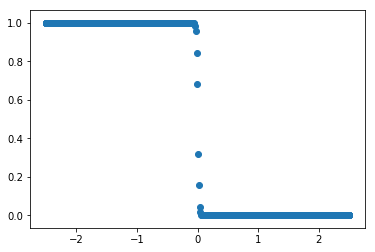

In [10]:
plt.scatter(w,np.diag(rho_diag))
plt.show()

Declaro una serie de arreglos vacíos que contendrán cosas que pretendo ir guardando durante la simulación, el tiempo, la traza, energía, corriente, etc...

In [11]:
time = []
trace = []
energy = []
current = []

# Integración

El algoritmo de integración que usamos es el siguiente:
$$ \rho(t+\Delta t)=\rho(t-\Delta t) + 2 \Delta t\ \dot\rho(t)$$
con
$$ \dot\rho(t) = -\frac{i}{\hbar} [H,\rho] $$
el algoritmo es un *leapfrog* que usa info del paso anterior y la derivada en el presente para encontrar la $\rho$ futura. Para inicializarlo hacemos un paso de Euler hacia atrás
$$\rho_{\mathrm old} = \rho_0 - \Delta t\ \dot\rho(t=0)$$

In [12]:
rho = rho_0
rhodot = ((0-1.0j)/hbar)*(np.dot(h,rho)-np.dot(rho,h))
rhoold = rho - dt*rhodot

Hasta ahora nuestra $\rho$ conmuta (por construcción) con el $H$ que armamos con bias, para lograr que evolucione armamos un nuevo Hamiltoniano eliminando el bias. Con esto tenemos un cable con un exceso de electrones del lado izquierdo y un defecto en el lado derecho.Con este nuevo Hamiltoniano deberíamos generar una corriente hacia la derecha. 

In [13]:
np.fill_diagonal(h,0.0)

h[int(nsites/2)-2,int(nsites/2)-1] = gamma
h[int(nsites/2)-1,int(nsites/2)  ] = delta
h[int(nsites/2)  ,int(nsites/2)+1] = gamma

h[int(nsites/2)-1,int(nsites/2)-2] = gamma
h[int(nsites/2)  ,int(nsites/2)-1] = delta
h[int(nsites/2)+1,int(nsites/2)  ] = gamma

Hacemos evolucionar $\rho$ por `nsteps` guardando a cada paso la información que nos interese. De nuevo este código no es la forma más elegante ni eficiente, está escrito para que sea fácil de entender.

In [14]:
for step in range(0,nsteps):
    rhodot = ((0-1.0j)/hbar)*(np.dot(h,rho)-np.dot(rho,h))
    rhonew = rhoold + 2.0 * dt * rhodot
    rhoold = rho
    rho = rhonew
    # calculate observables
    time.append(step*dt)
    trace.append(2.0*np.trace(rho).real)
    energy.append(np.trace(np.dot(h,rho)).real)
    current.append(4.0 * h[int(nsites/2)-1,int(nsites/2)].real * rho[int(nsites/2),int(nsites/2)-1].imag )

Nuestro algoritmo conserva la traza de forma numéricamente exacta.

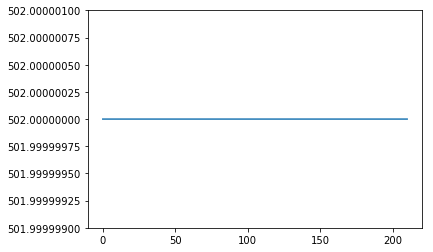

In [15]:
plt.plot(time,trace)
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.ylim((2.0*np.trace(rho_0)-0.000001,2.0*np.trace(rho_0)+0.000001))
plt.show()

Y también debería conservar la energía.

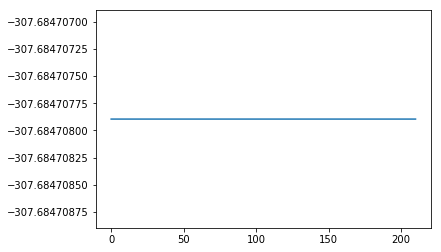

In [16]:
plt.plot(time,energy)
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.ylim(np.trace(np.dot(h,rho)).real-0.000001,np.trace(np.dot(h,rho)).real+0.000001)
plt.show()

Y acá está ahora lo más interesante de todo! Qué pasa con la corriente?

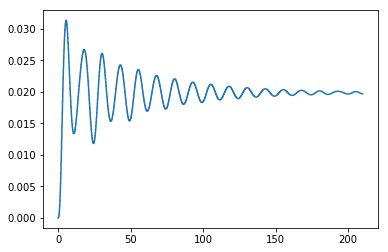

In [17]:
plt.plot(time,current)
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.show()